# Conda GreenSurge faugeree

In [1]:
from datetime import datetime

import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import ocsmesh
import pyproj
import xarray as xr
from bluemath_tk.topo_bathy.mesh_utils import (
    adcirc2netcdf,
    buffer_aera,
    clip_bathymetry,
    define_mesh_target_size,
    detect_circumcenter_too_close,
    mask_points_outside_polygon,
    plot_bathymetry,
    plot_bathymetry_interp,
    plot_boundaries,
    plot_mesh_edge,
    plot_mesh_vals,
    read_adcirc_grd,
)
from bluemath_tk.topo_bathy.OCSMod import EuclideanMesh2D
from pyproj import CRS
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import transform

## General parameters

### Names and paths

In [ ]:
bathymetry_tif_raw_path = "/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/inputs/Tonga_inv_V2.tif"

initial_raster_paths = [bathymetry_tif_raw_path]
outputs_bathy_clip_tif_path = "/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/NOAA_10m_6634_LMSL_clip.tif"

site = "Tonga"

### GreenSurge parameters

In [3]:
wind_speed = 40
direction_step = 15
simulation_duration_hours = 12
simulation_time_step_hours = 1
forcing_time_step = simulation_time_step_hours

reference_date = [2022, 1, 1, 0, 0, 0]
reference_date_dt = datetime(*reference_date)

Eddy = 10
Chezy = 70

In [4]:
# Forcing Setup
forcing_cell_size = 19 * 1000
Wind_effect_max_depth = -150

Mean_Sea_Level = 0


In [5]:
point = Point(-175.18531, -21.20102)

coords = [
    [-175.4842625874, -20.6200013383],
    [-174.7444556220, -20.6187918446],
    [-174.7446572043, -21.6460551405],
    [-175.4845145652, -21.6468110740],
    [-175.4842625874, -20.6200013383],
]

In [6]:
lon_center = np.mean(np.array(coords)[-1, 0])
lat_center = np.mean(np.array(coords)[-1, 1])

proj_str = (
    f"+proj=aeqd +lat_0={lat_center} +lon_0={lon_center} +units=m +datum=WGS84 +no_defs"
)
project = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True).transform

## Raster

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

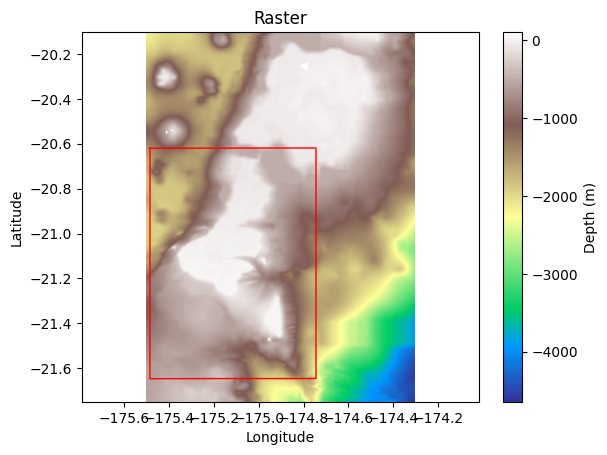

In [7]:
domain_crs = CRS.from_user_input("epsg:4326")
domain_polygon = Polygon(coords)


fig, ax = plt.subplots()
plot_bathymetry(initial_raster_paths, domain_polygon, ax)

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

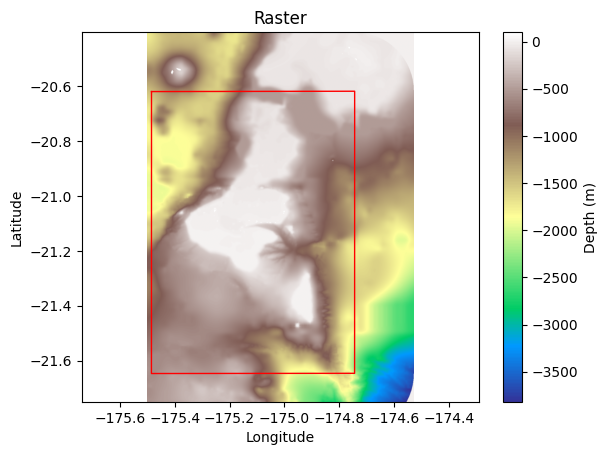

In [ ]:
raster_resolution = clip_bathymetry(
    input_raster_paths=initial_raster_paths,
    outputs_path=outputs_bathy_clip_tif_path,
    domain=domain_polygon,
    margin=1,
)
clipped_raster_paths = [outputs_bathy_clip_tif_path]

x_center, y_center = project(lon_center, lat_center)
x_center_raster_resolution, y_center_raster_resolution = project(
    lon_center + raster_resolution / np.sqrt(2),
    lat_center + raster_resolution / np.sqrt(2),
)
raster_resolution_meters = np.mean(
    [
        abs(x_center - x_center_raster_resolution),
        abs(y_center - y_center_raster_resolution),
    ]
)

fig, ax = plt.subplots()
plot_bathymetry(clipped_raster_paths, domain_polygon, ax)

## Computacional Grid

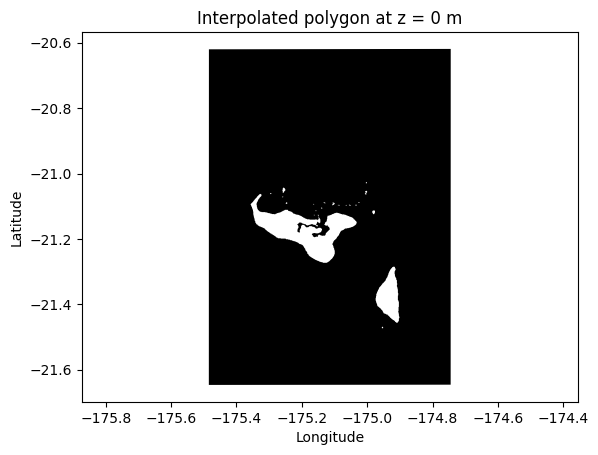

In [10]:
rasters = [ocsmesh.Raster(path) for path in clipped_raster_paths]
coastal_area = ocsmesh.Geom(rasters, zmax=Mean_Sea_Level).get_multipolygon()
intersected = coastal_area.intersection(domain_polygon)
if isinstance(intersected, MultiPolygon):
    intersected_area = max(intersected.geoms, key=lambda p: p.area)
else:
    intersected_area = intersected

gpd.GeoSeries(intersected_area).plot(color="black")
plt.axis("equal")
plt.title(f"Interpolated polygon at z = {Mean_Sea_Level} m")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

(np.float64(654888.2121234806),
 np.float64(757857.0251835132),
 np.float64(7592799.336446861),
 np.float64(7743206.283646412))

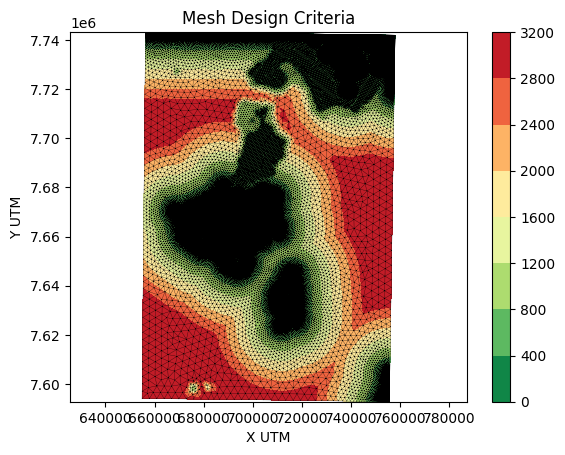

In [11]:
geometry = ocsmesh.Geom(
    [],
    base_shape=intersected_area,
    base_shape_crs=domain_crs,
)
domain_multipolygon = geometry.get_multipolygon()

# Define depth zones with mesh size and transition rate per range
# Format: (lower_bound, upper_bound): {'value': mesh_size, 'rate': expansion_rate}
expention_rate = 0.001
depth_ranges = {
    (-200_000, -250): {"value": 3000, "rate": expention_rate},  # Very deep ocean
    (-250, -100): {"value": 1000, "rate": expention_rate},  # Continental slope
    (-100, -75): {"value": 800, "rate": expention_rate},  # Outer shelf
    (-75, -25): {"value": 500, "rate": expention_rate},  # Mid shelf
    (-25, 2.5): {"value": 100, "rate": expention_rate},  # Coastal zone
}

mesh_spacing = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges, nprocs=16
)

mesh_spacing_field = mesh_spacing.msh_t()
ax = plot_mesh_vals(mesh_spacing_field, cmap="RdYlGn_r")
plot_mesh_edge(mesh_spacing_field, lw=0.2, color="black", ax=ax)
ax.axis("equal")

In [12]:
driver = ocsmesh.JigsawDriver(geom=geometry, hfun=mesh_spacing, initial_mesh=False)
mesh = driver.run(remesh_tiny_elements=True)
mesh.interpolate(rasters, method="linear")

In [13]:
copy_mesh = EuclideanMesh2D(mesh.msh_t)
data_mesh = copy_mesh.vert2
node_coords = np.array([item["coord"] for item in data_mesh])
elements = np.array(list(ocsmesh.utils.elements(mesh.msh_t).values()))

In [14]:
to_utm = pyproj.Transformer.from_crs(
    "EPSG:4326", mesh_spacing_field.crs, always_xy=True
).transform
intersected_area_UTM = Polygon(transform(to_utm, intersected_area).exterior.coords)
intersected_area_UTM_extended = buffer_aera(intersected_area_UTM, 0.01)

mask_generation_outside = mask_points_outside_polygon(
    elements, node_coords, intersected_area_UTM_extended
)
print(f"Number of elements outside the polygon: {mask_generation_outside.sum()}")

mask_circumcenter = detect_circumcenter_too_close(
    node_coords[:, 0], node_coords[:, 1], elements
)
print(f"Number of elements with circumcenter too close: {mask_circumcenter.sum()}")

complete_mask = mask_generation_outside | mask_circumcenter

Number of elements outside the polygon: 0
Number of elements with circumcenter too close: 4


Text(0, 0.5, 'Latitude UTM')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


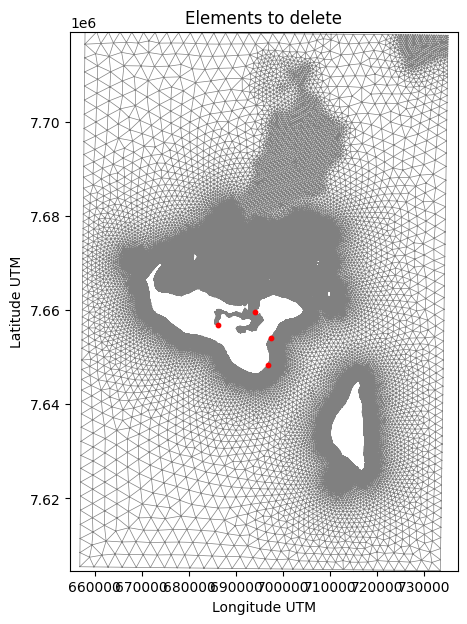

In [15]:
bad_elements = np.mean(node_coords[elements[complete_mask]], axis=1)
fig, ax = plt.subplots(figsize=(5, 7))
ax.triplot(node_coords[:, 0], node_coords[:, 1], elements, color="gray", lw=0.5)
ax.scatter(
    bad_elements[:, 0].flatten(),
    bad_elements[:, 1].flatten(),
    color="red",
    s=10,
    label="circumcenter",
)
ax.axis("equal")
ax.set_title("Elements to delete")
ax.set_xlim(min(node_coords[:, 0]), max(node_coords[:, 0]))
ax.set_ylim(min(node_coords[:, 1]), max(node_coords[:, 1]))
ax.set_xlabel("Longitude UTM")
ax.set_ylabel("Latitude UTM")

In [16]:
cleaned_mesh = ocsmesh.utils.clip_elements_by_index(
    copy_mesh, tria=complete_mask, quad=None
)
ocsmesh.utils.finalize_mesh(cleaned_mesh)

No Land boundaries available. Error: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.


(np.float64(656827.4731120444),
 np.float64(735052.0393815765),
 np.float64(7604653.736184375),
 np.float64(7719171.0892651025))

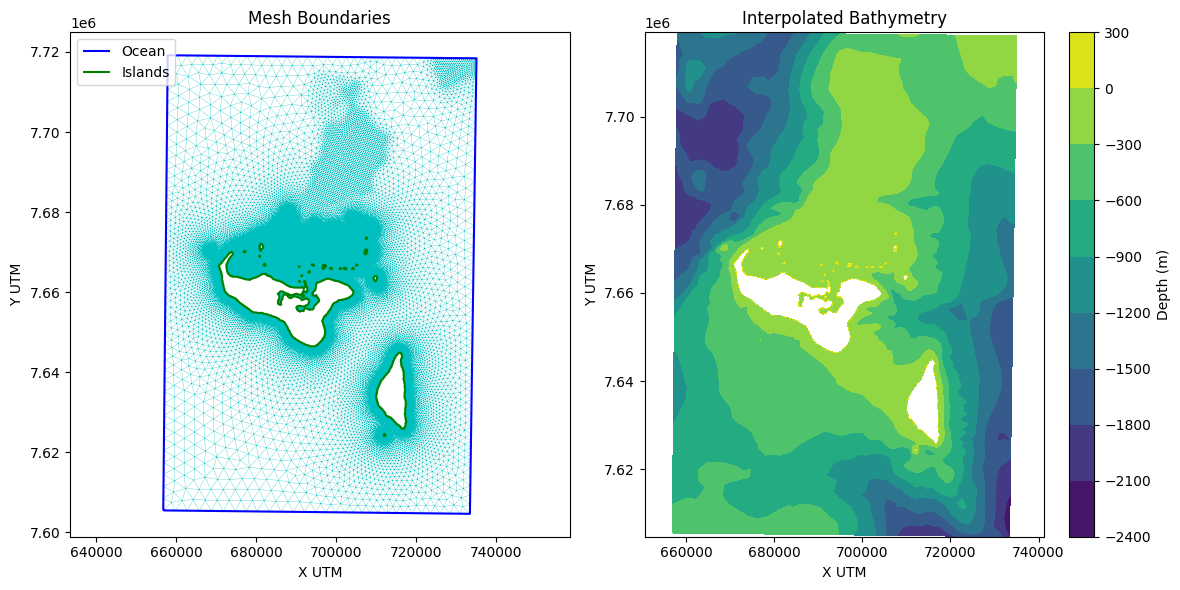

In [17]:
cleaned_mesh.interpolate(rasters, method="linear")
cleaned_mesh.boundaries.auto_generate(Mean_Sea_Level)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_boundaries(cleaned_mesh, ax1)
plot_bathymetry_interp(cleaned_mesh, ax2)
plt.tight_layout()
plt.axis("equal")

In [ ]:
path_grd_calc = f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/mesh_{site}_Calc_adcirc.grd"
cleaned_mesh.write(path_grd_calc, format="grd", overwrite=True)

In [ ]:
netcdf_path = f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/mesh_{site}_net.nc"
adcirc2netcdf(path_grd_calc, netcdf_path)

## Forcing Grid

Text(130.73626028721367, 0.5, 'Latitude')

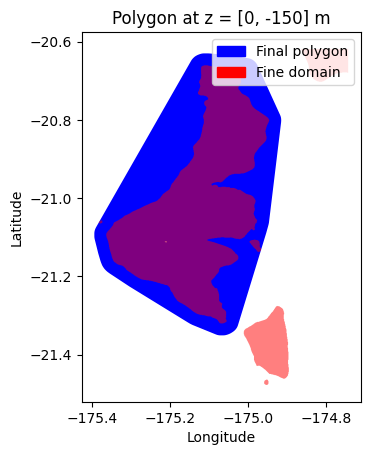

In [20]:
coarse_domain_clipped = (
    ocsmesh.Geom(rasters, zmax=Mean_Sea_Level)
    .get_multipolygon()
    .intersection(domain_polygon)
)
fine_domain_clipped = (
    ocsmesh.Geom(rasters, zmin=Wind_effect_max_depth)
    .get_multipolygon()
    .intersection(domain_polygon)
)

for polygon in fine_domain_clipped.geoms:
    if polygon.contains(point):
        selected_polygon = polygon
        break

envelope = selected_polygon.convex_hull
coarse_minus_envelope = coarse_domain_clipped.difference(envelope)
refined_shape = coarse_domain_clipped.difference(coarse_minus_envelope)

if isinstance(refined_shape, MultiPolygon):
    largest_polygon = max(refined_shape.geoms, key=lambda p: p.area)
else:
    largest_polygon = refined_shape

cleaned_polygon = Polygon(largest_polygon.exterior)
outer_buffered = buffer_aera(cleaned_polygon, 0.3)
inner_buffered = buffer_aera(selected_polygon, -2)

final_polygon = outer_buffered.difference(inner_buffered)

fig, ax = plt.subplots()
gpd.GeoSeries(final_polygon).plot(ax=ax, color="blue")
gpd.GeoSeries(fine_domain_clipped).plot(ax=ax, color="red", alpha=0.5)

final_polygon_patch = mpatches.Patch(color="blue", label="Final polygon")
fine_domain_patch = mpatches.Patch(color="red", label="Fine domain")
ax.legend(handles=[final_polygon_patch, fine_domain_patch], loc="best")
ax.set_title(f"Polygon at z = [{Mean_Sea_Level}, {Wind_effect_max_depth}] m")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

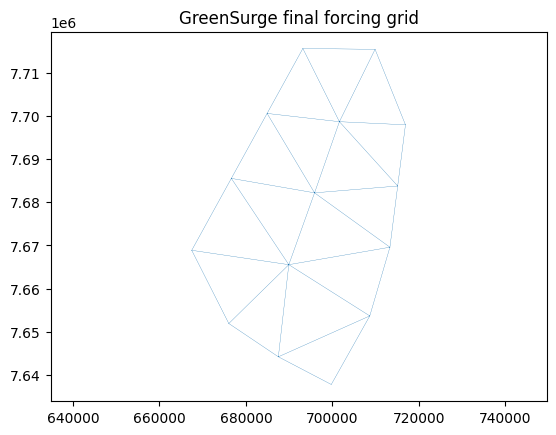

In [21]:
geom_forz = ocsmesh.Geom(
    [],
    base_shape=final_polygon,
    base_shape_crs=domain_crs,
)
domain_poly = geom_forz.get_multipolygon()

depth_ranges_forcing = {
    (-200_000, -250): {"value": forcing_cell_size, "rate": None},
}

hfun_forz = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges_forcing
)

driver_forz = ocsmesh.JigsawDriver(
    geom=geom_forz,
    hfun=hfun_forz,
    initial_mesh=False,
)
mesh_forz = driver_forz.run()

fig, ax = plt.subplots()
ax.triplot(
    mesh_forz.msh_t.vert2["coord"][:, 0],
    mesh_forz.msh_t.vert2["coord"][:, 1],
    triangles=mesh_forz.msh_t.tria3["index"],
    lw=0.2,
)
ax.axis("equal")
plt.title("GreenSurge final forcing grid")

plt.show()

In [ ]:
path_grd_forz = f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/mesh_{site}_Viento_adcirc.grd"
mesh_forz.write(path_grd_forz, format="grd", overwrite=True)

## GreenSurge Setup Summary

In [23]:
Nodes_calc, Elmts_calc, lines_calc = read_adcirc_grd(path_grd_calc)
Nodes_forz, Elmts_forz, lines_forz = read_adcirc_grd(path_grd_forz)

### Presentacion malla

Text(0.5, 1.0, 'GreenSurge Mesh Setup')

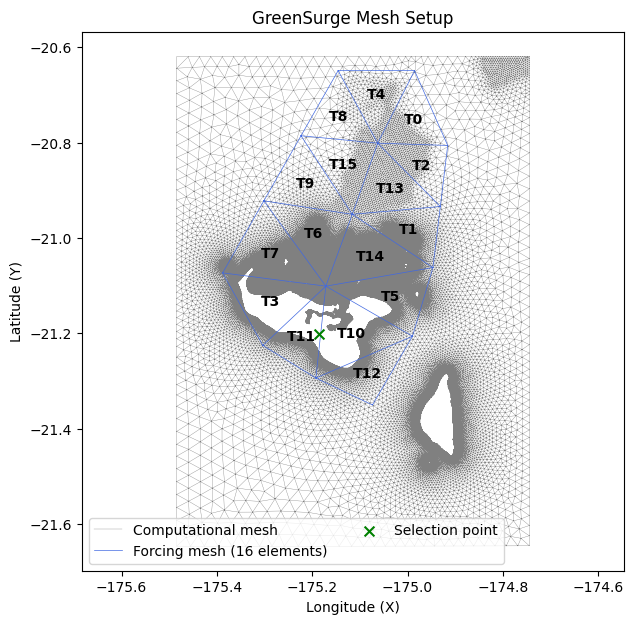

In [24]:
num_elements = len(Elmts_forz)
fig, ax = plt.subplots(figsize=[7, 7])
ax.triplot(
    Nodes_calc[:, 1],
    Nodes_calc[:, 2],
    Elmts_calc[:, 2:5],
    color="grey",
    linestyle="-",
    marker="",
    linewidth=1 / 4,
    label="Computational mesh",
)
ax.triplot(
    Nodes_forz[:, 1],
    Nodes_forz[:, 2],
    Elmts_forz[:, 2:5],
    color="royalblue",
    linestyle="-",
    marker="",
    linewidth=1 / 2,
    label=f"Forcing mesh ({num_elements} elements)",
)
ax.scatter(
    point.coords[0][0],
    point.coords[0][1],
    marker="x",
    color="green",
    s=50,
    label="Selection point",
)

for t in range(num_elements):
    node0, node1, node2 = Elmts_forz[t, 2:5]
    x = (
        Nodes_forz[int(node0), 1]
        + Nodes_forz[int(node1), 1]
        + Nodes_forz[int(node2), 1]
    ) / 3
    y = (
        Nodes_forz[int(node0), 2]
        + Nodes_forz[int(node1), 2]
        + Nodes_forz[int(node2), 2]
    ) / 3
    plt.text(x, y, f"T{t}", fontsize=10, ha="center", va="center", fontweight="bold")

ax.set_xlim(Nodes_forz[:, 1].min(), Nodes_forz[:, 1].max())
ax.set_ylim(Nodes_forz[:, 2].min(), Nodes_forz[:, 2].max())
ax.axis("equal")
plt.legend(ncols=2)
ax.set_xlabel("Longitude (X)")
ax.set_ylabel("Latitude (Y)")
ax.set_title("GreenSurge Mesh Setup")

### Build simulation_dataset

In [25]:
triangle_node_indices = np.arange(3)

num_directions = int(360 / direction_step)
wind_directions = np.arange(0, 360, direction_step)
wind_direction_indices = np.arange(0, num_directions)

element_forcing_indices = np.arange(0, num_elements)
element_computation_indices = np.arange(0, len(Elmts_calc[:, 1]))

node_forcing_indices = np.arange(0, len(Nodes_forz[:, 1]))

time_forcing_index = [0, 1, 1.01, simulation_duration_hours - 1]

node_cumputation_index = np.arange(0, len(Nodes_calc[:, 1]))

reference_date_str = reference_date_dt.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
simulation_dataset = xr.Dataset(
    coords=dict(
        wind_direction_index=("wind_direction_index", wind_direction_indices),
        time_forcing_index=("time_forcing_index", time_forcing_index),
        node_computation_longitude=("node_cumputation_index", Nodes_calc[:, 1]),
        node_computation_latitude=("node_cumputation_index", Nodes_calc[:, 2]),
        triangle_nodes=("triangle_forcing_nodes", triangle_node_indices),
        node_forcing_index=("node_forcing_index", node_forcing_indices),
        element_forcing_index=("element_forcing_index", element_forcing_indices),
        node_cumputation_index=("node_cumputation_index", node_cumputation_index),
        element_computation_index=("element_computation_index", element_computation_indices),

    ),
    data_vars=dict(
        triangle_computation_connectivity=(("element_computation_index", "triangle_forcing_nodes"), Elmts_calc[:, 2:5].astype(int),
            {"description": "Indices of nodes forming each triangular element of the computational grid (counter-clockwise order)"}),

        node_forcing_longitude=("node_forcing_index", Nodes_forz[:, 1],
            {"units": "degrees_east", "description": "Longitude of each mesh node of the forcing grid"}),
        node_forcing_latitude=("node_forcing_index", Nodes_forz[:, 2],
            {"units": "degrees_north", "description": "Latitude of each mesh node of the forcing grid"}),
        triangle_forcing_connectivity=(("element_forcing_index", "triangle_forcing_nodes"), Elmts_forz[:, 2:5].astype(int),
            {"description": "Indices of nodes forming each triangular element of the forcing grid (counter-clockwise order)"}),

        wind_directions=("wind_direction_index", wind_directions,
            {"units": "degrees", "description": "Discretized wind directions (0 to 360°)"}),
        total_elements=((), num_elements,
            {"description": "Total number of triangular elements in the mesh"}),
        simulation_duration_hours=((), simulation_duration_hours,
            {"units": "hours", "description": "Total duration of the simulation"}),
        time_step_hours=((), simulation_time_step_hours,
            {"units": "hours", "description": "Time step used in the simulation"}),
        wind_speed=((), wind_speed,
            {"units": "m/s", "description": "Wind speed for each discretized direction"}),
        location_name=((), site,
            {"description": "Name of case study location"}),
        eddy_viscosity=((), Eddy,
            {"units": "m²/s", "description": "Eddy viscosity used in the simulation"}),
        chezy_coefficient=((), Chezy,
            {"description": "Chezy coefficient used for bottom friction"}),
        reference_date=((), reference_date_str,
            {"description": "Reference start date of the simulation"}),
        forcing_time_step=((), forcing_time_step,
            {"units": "hour", "description": "Time step used for applying external forcing data"}),
    )
)

simulation_dataset["time_forcing_index"].attrs = {
    "standard_name": "time",
    "long_name": f"Time - hours since {reference_date_str} +00:00",
    "time_origin": f"{reference_date_str}",
    "units": f"hours since {reference_date_str} +00:00",
    "calendar": "gregorian",
    "description": "Time definition for the forcing data",
}

simulation_dataset["node_computation_longitude"].attrs = {
    "description": "Longitude of each mesh node of the computational grid",
    "standard_name": "longitude",
    "long_name": "longitude",
    "units": "degrees_east"
}
simulation_dataset["node_computation_latitude"].attrs = {
    "description": "Latitude of each mesh node of the computational grid",
    "standard_name": "latitude",
    "long_name": "latitude",
    "units": "degrees_north"
}


simulation_dataset.attrs = {
    "title": "Hybrid Simulation Input Dataset",
    "description": "Structured dataset containing simulation parameters for hybrid modeling.",
    "created": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "institution": "GeoOcean",
    "model": "GreenSurge",
}

simulation_dataset.to_netcdf(
    f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/GreenSurge{site}_info.nc",
    "w",
    "NETCDF3_CLASSIC",
    unlimited_dims="time",
)

In [27]:
simulation_dataset

<xarray.Dataset> Size: 7MB
Dimensions:                            (element_computation_index: 151075,
                                        triangle_forcing_nodes: 3,
                                        node_forcing_index: 15,
                                        element_forcing_index: 16,
                                        wind_direction_index: 24,
                                        time_forcing_index: 4,
                                        node_cumputation_index: 76752)
Coordinates:
  * wind_direction_index               (wind_direction_index) int64 192B 0 .....
  * time_forcing_index                 (time_forcing_index) float64 32B 0.0 ....
    node_computation_longitude         (node_cumputation_index) float64 614kB ...
    node_computation_latitude          (node_cumputation_index) float64 614kB ...
    triangle_nodes                     (triangle_forcing_nodes) int64 24B 0 1 2
  * node_forcing_index                 (node_forcing_index) int64 120B 0 ... 14
  * element_forcing_index              (element_forcing_index) int64 128B 0 ....
  * node_cumputation_index             (node_cumputation_index) int64 614kB 0...
  * element_computation_index          (element_computation_index) int64 1MB ...
Dimensions without coordinates: triangle_forcing_nodes
Data variables: (12/14)
    triangle_computation_connectivity  (element_computation_index, triangle_forcing_nodes) int64 4MB ...
    node_forcing_longitude             (node_forcing_index) float64 120B -175...
    node_forcing_latitude              (node_forcing_index) float64 120B -21....
    triangle_forcing_connectivity      (element_forcing_index, triangle_forcing_nodes) int64 384B ...
    wind_directions                    (wind_direction_index) int64 192B 0 .....
    total_elements                     int64 8B 16
    ...                                 ...
    wind_speed                         int64 8B 40
    location_name                      <U5 20B 'Tonga'
    eddy_viscosity                     int64 8B 10
    chezy_coefficient                  int64 8B 70
    reference_date                     <U19 76B '2022-01-01 00:00:00'
    forcing_time_step                  int64 8B 1
Attributes:
    title:        Hybrid Simulation Input Dataset
    description:  Structured dataset containing simulation parameters for hyb...
    created:      2025-05-19 11:33:29
    institution:  GeoOcean
    model:        GreenSurge